<a href="https://colab.research.google.com/github/Savvy-Slowley/CPI-for-All-Urban-Consumers-All-Items-Except-Food-Energy/blob/main/CPI_for_All_Urban_Consumers_All_Items_Except_Food_Energy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import csv

In [2]:
CPI = '/content/CPI for All Urban Consumers (Jan 1957 - Jul 2022).csv'

with open(CPI, 'r') as csvfile:
    print(f"Header looks like this:\n\n{csvfile.readline()}")    
    print(f"First data point looks like this:\n\n{csvfile.readline()}")
    print(f"Second data point looks like this:\n\n{csvfile.readline()}")

Header looks like this:

Year,Change ,Month/Year

First data point looks like this:

1958,3.2,Jan 1958

Second data point looks like this:

1958,3.2,Feb 1958



In [3]:
def plot_series(x, y, format="-", start=0, end=None, 
                title=None, xlabel=None, ylabel=None, legend=None ):
    """
    Visualizes time series data

    Args:
      x (array of int) - contains values for the x-axis
      y (array of int or tuple of arrays) - contains the values for the y-axis
      format (string) - line style when plotting the graph
      start (int) - first time step to plot
      end (int) - last time step to plot
      title (string) - title of the plot
      xlabel (string) - label for the x-axis
      ylabel (string) - label for the y-axis
      legend (list of strings) - legend for the plot
    """

    # Setup dimensions of the graph figure
    plt.figure(figsize=(26, 6))
    
    # Check if there are more than two series to plot
    if type(y) is tuple:

      # Loop over the y elements
      for y_curr in y:

        # Plot the x and current y values
        plt.plot(x[start:end], y_curr[start:end], format)

    else:
      # Plot the x and y values
      plt.plot(x[start:end], y[start:end], format)

    # Label the x-axis
    plt.xlabel(xlabel)

    # Label the y-axis
    plt.ylabel(ylabel)

    # Set the legend
    if legend:
      plt.legend(legend)

    # Set the title
    plt.title(title)

    # Overlay a grid on the graph
    plt.grid(True)

    # Draw the graph on screen
    plt.show()

In [4]:
def plot_series_2(time, series, format="-", start=0, end=None):
    plt.figure(figsize=(16, 6))
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time", fontsize = 15)
    plt.ylabel("Value", fontsize = 15)
    # Show first and last number
    plt.xticks([time[0], time[-1]])
    plt.grid(axis='y', color='k', alpha=.5)

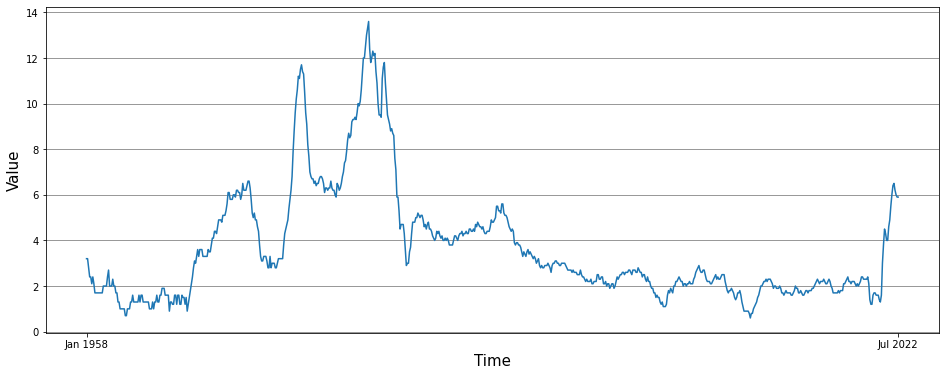

In [5]:
# Initialize lists
percent = []
months = []

# Open CSV file
with open(CPI) as csvfile:
  
  # Initialize reader
  reader = csv.reader(csvfile, delimiter=',')
  
  # Skip the first line
  next(reader)
  
  # Append times and percentage of number to lists
  for row in reader:
    percent.append(float(row[1]))
    months.append(row[2])

# Convert lists to numpy arrays
percent = np.array(percent)
c = np.array(months)

# Preview the data
plot_series_2(months, percent)
plt.show()

In [6]:
print("Number of Months:",len(months))

Number of Months: 775


In [7]:
# Define the split time
split_month = 750

# Get the train set 
time_train = months[:split_month]
x_train = percent[:split_month]

# Get the validation set
time_valid = months[split_month:]
x_valid = percent[split_month:]

In [8]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    """Generates dataset windows

    Args:
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the feature
      batch_size (int) - the batch size
      shuffle_buffer(int) - buffer size to use for the shuffle method

    Returns:
      dataset (TF Dataset) - TF Dataset containing time windows
    """
  
    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)
    
    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    
    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))

    # Create tuples with features and labels 
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))

    # Shuffle the windows
    dataset = dataset.shuffle(shuffle_buffer)
    
    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)
    
    return dataset

In [9]:
# Parameters
window_size = 25
batch_size = 32
shuffle_buffer_size = 256

# Generate the dataset windows
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

In [10]:
# Build the Model
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=64, kernel_size=3,
                      strides=1,
                      activation="relu",
                      padding='causal',
                      input_shape=[window_size, 1]),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

 # Print the model summary 
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 25, 64)            256       
                                                                 
 bidirectional (Bidirectiona  (None, 25, 64)           24832     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               24832     
 nal)                                                            
                                                                 
 dense (Dense)               (None, 30)                1950      
                                                                 
 dense_1 (Dense)             (None, 10)                310       
                                                                 
 dense_2 (Dense)             (None, 1)                 1

In [11]:
# Get initial weights
init_weights = model.get_weights()

In [12]:
# Reset states generated by Keras
tf.keras.backend.clear_session()

# Reset the weights
model.set_weights(init_weights)

In [13]:
# Set the learning rate scheduler
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))

# Initialize the optimizer
optimizer = tf.keras.optimizers.SGD(momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer)

# Train the model
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
23/23 [==============================] - 5s 35ms/step - loss: 17.2717 - lr: 1.0000e-08
Epoch 2/100
23/23 [==============================] - 1s 25ms/step - loss: 15.0531 - lr: 1.1220e-08
Epoch 3/100
23/23 [==============================] - 1s 24ms/step - loss: 12.3311 - lr: 1.2589e-08
Epoch 4/100
23/23 [==============================] - 1s 24ms/step - loss: 9.3429 - lr: 1.4125e-08
Epoch 5/100
23/23 [==============================] - 1s 24ms/step - loss: 6.0737 - lr: 1.5849e-08
Epoch 6/100
23/23 [==============================] - 1s 25ms/step - loss: 3.0493 - lr: 1.7783e-08
Epoch 7/100
23/23 [==============================] - 1s 24ms/step - loss: 1.7034 - lr: 1.9953e-08
Epoch 8/100
23/23 [==============================] - 1s 24ms/step - loss: 1.4659 - lr: 2.2387e-08
Epoch 9/100
23/23 [==============================] - 1s 25ms/step - loss: 1.2647 - lr: 2.5119e-08
Epoch 10/100
23/23 [==============================] - 1s 24ms/step - loss: 1.1055 - lr: 2.8184e-08
Epoch 11/100
23/

(1e-08, 0.001, 0.0, 100.0)

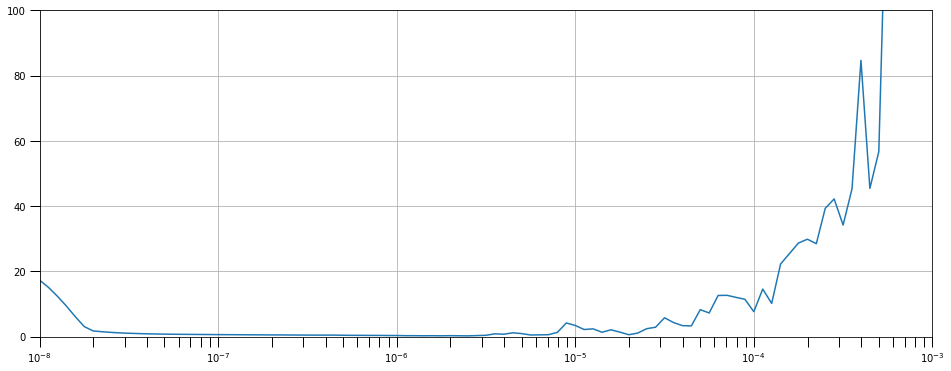

In [14]:
# Define the learning rate array
lrs = 1e-8 * (10 ** (np.arange(100) / 20))

# Set the figure size
plt.figure(figsize=(16, 6))

# Set the grid
plt.grid(True)

# Plot the loss in log scale
plt.semilogx(lrs, history.history["loss"])

# Increase the tickmarks size
plt.tick_params('both', length=10, width=1, which='both')

# Set the plot boundaries
plt.axis([1e-8, 1e-3, 0, 100])

In [15]:
# Reset states generated by Keras
tf.keras.backend.clear_session()

# Reset the weights
model.set_weights(init_weights)

In [16]:
# Set the learning rate
learning_rate = 2.5e-6

# Set the optimizer 
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

In [17]:
history = model.fit(train_set, epochs=500)

Epoch 1/500
23/23 [==============================] - 5s 24ms/step - loss: 5.5997 - mae: 6.0888
Epoch 2/500
23/23 [==============================] - 1s 24ms/step - loss: 1.7470 - mae: 2.1958
Epoch 3/500
23/23 [==============================] - 1s 24ms/step - loss: 0.6272 - mae: 1.0187
Epoch 4/500
23/23 [==============================] - 1s 24ms/step - loss: 0.3929 - mae: 0.7444
Epoch 5/500
23/23 [==============================] - 1s 42ms/step - loss: 0.3341 - mae: 0.6736
Epoch 6/500
23/23 [==============================] - 1s 25ms/step - loss: 0.2873 - mae: 0.6134
Epoch 7/500
23/23 [==============================] - 1s 24ms/step - loss: 0.2923 - mae: 0.6209
Epoch 8/500
23/23 [==============================] - 1s 24ms/step - loss: 0.2940 - mae: 0.6271
Epoch 9/500
23/23 [==============================] - 1s 23ms/step - loss: 0.2247 - mae: 0.5277
Epoch 10/500
23/23 [==============================] - 1s 24ms/step - loss: 0.2197 - mae: 0.5296
Epoch 11/500
23/23 [=============================

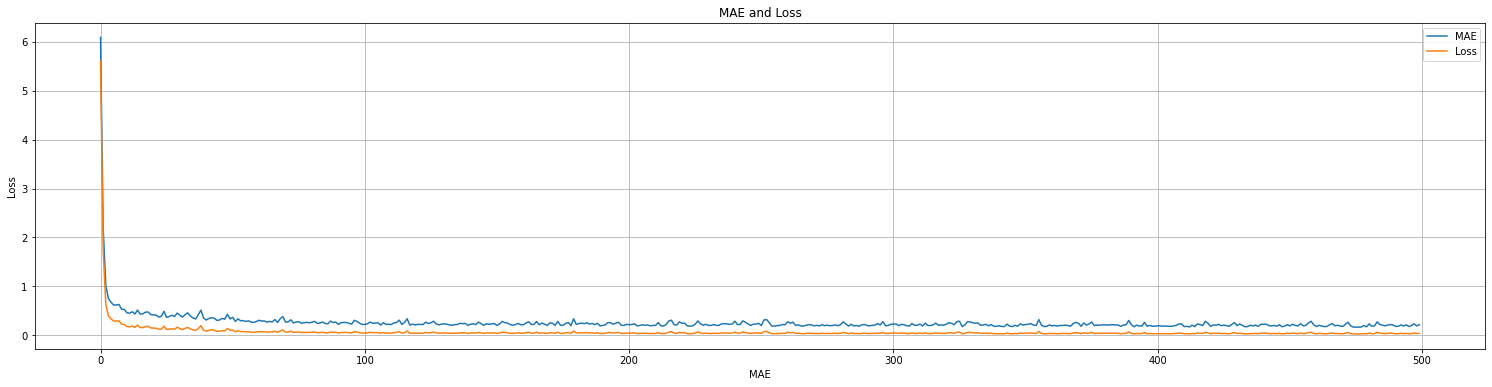

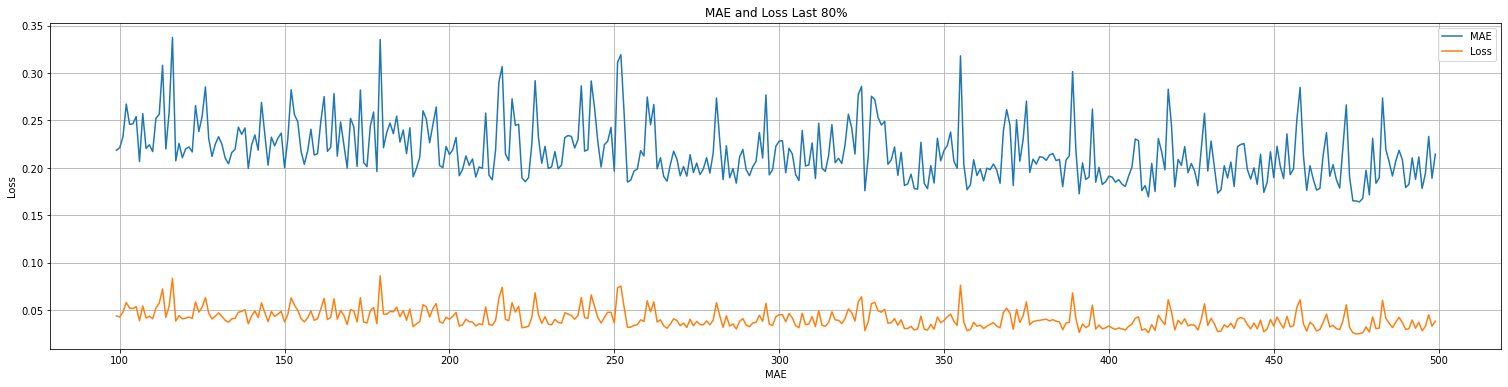

In [18]:
# Get mae and loss from history log
mae=history.history['mae']
loss=history.history['loss']

# Get number of epochs
epochs=range(len(loss)) 

# Plot mae and loss
plot_series(
    x=epochs, 
    y=(mae, loss), 
    title='MAE and Loss', 
    xlabel='MAE',
    ylabel='Loss',
    legend=['MAE', 'Loss']
    )

# Only plot the last 80% of the epochs
zoom_split = int(epochs[-1] * 0.2)
epochs_zoom = epochs[zoom_split:]
mae_zoom = mae[zoom_split:]
loss_zoom = loss[zoom_split:]

# Plot zoomed mae and loss
plot_series(
    x=epochs_zoom, 
    y=(mae_zoom, loss_zoom), 
    title='MAE and Loss Last 80%', 
    xlabel='MAE',
    ylabel='Loss',
    legend=['MAE', 'Loss']
    )

In [19]:
def model_forecast(model, series, window_size, batch_size):
    """Uses an input model to generate predictions on data windows

    Args:
      model (TF Keras Model) - model that accepts data windows
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the window
      batch_size (int) - the batch size

    Returns:
      forecast (numpy array) - array containing predictions
    """

    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda w: w.batch(window_size))
    
    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)
    
    # Get predictions on the entire dataset
    forecast = model.predict(dataset)
    
    return forecast

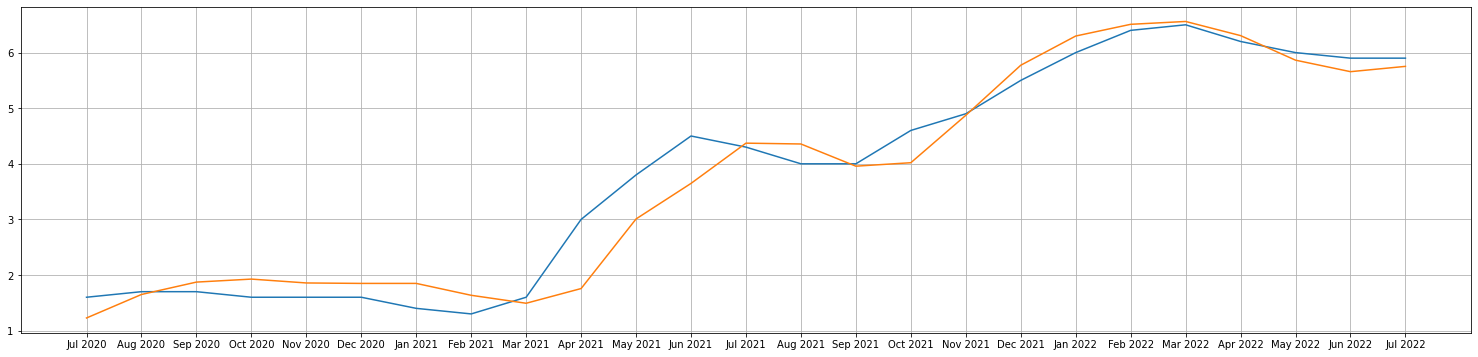

In [20]:
# Reduce the original series
forecast_series = percent[split_month-window_size:-1]

# Use helper function to generate predictions
forecast = model_forecast(model, forecast_series, window_size, batch_size)

# Drop single dimensional axis
results = forecast.squeeze()

# Plot the results
plot_series(time_valid, (x_valid, results))

In [21]:
# Compute the MAE
print(tf.keras.metrics.mean_absolute_error(x_valid, results).numpy())

0.30632707
